# SGD and its variants

We are going to investigate following SGD-family methods:
* Batch Gradient Descent
* Stochastic Gradient Descent
* Mini-Batch Gradient Descent

and several descent techniques including:
* (Naive) Gradient Descent
* Momentum
* SAG: Stochastic Average Gradient

We will also investigate how the following factors affect:
* Data size 
* Data noise level
* Learning rate
* Batch size

Our target problem is Logistic Regression and it's obviously convex. We will use both public dataset and own data simulation using sklearn functions.

## Implementations:

* Logistic Regression (Loss, Gradient, ....)
* Data Preprocessing (Fold split, batch prepartion, ...)
* Descent Methos

In [65]:
import numpy as np
from sklearn.datasets import make_classification
import time
from math import exp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from random import seed
from random import randrange
from csv import reader
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

X1, y1 = make_classification(n_samples=1000)


In [2]:
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

filename = 'pima-indians-diabetes.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
X2 = np.array(dataset)[:,:-1]
y2 = np.array(dataset)[:,-1]

In [3]:
sigmoid = lambda z : 1 / (1 + np.exp(-z))
logloss = lambda y_hat, y : np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / len(y_hat)
# logloss = lambda y_hat, y : np.sum(-y * (y_hat) + np.log(1 + np.exp(y_hat))) / len(y_hat)
predict = lambda X: sigmoid(np.dot(X, betas.T)) > .5
predict_with_output = lambda X: (X > .5) * 1


def gradient_descent(X, y, beta, lr):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    new_betas = beta - lr * gradients.T

    return new_betas, gradients

def momentum_descent(X, y, beta, lr, prev_grad, alpha=0.99):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    new_betas = beta - lr * gradients.T + alpha * prev_grad.T

    return new_betas, gradients

def saga_descent(X, y, beta, lr, grad, idx):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    grad[idx] = gradients
    d = np.sum(np.array(grad),axis=0)
    new_betas = beta - (lr / len(grad)) * d.T
    
    return new_betas, grad
    
    

def prepare_batches(X, y, batch_size):
    X_batch_list = list()
    y_batch_list = list()
    
    for i in range(len(y) // batch_size):
        X_batch_list.append(X[i * batch_size : i * batch_size + batch_size, :])
        y_batch_list.append(y[i * batch_size : i * batch_size + batch_size])
    
    if len(y) % batch_size > 0:
        X_batch_list.append(X[len(y) // batch_size * batch_size:, :])
        y_batch_list.append(y[len(y) // batch_size * batch_size:])

    return X_batch_list, y_batch_list

We notice that BGD and SGD are specific Mini-Batch GD with batch size equals to number of smaples in the whole dataset or 1.

In [42]:
def BGD(X_train,y_train,X_test,y_test,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,                                                            
                                                            lr=lr,
                                                            batch_size=X_train.shape[0],
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,
                                                            momentum=momentum,
                                                            saga=saga,
                                                            auto_lr=auto_lr)
    return train_error_hist, test_error_hist, test_acc_hist


def SGD(X_train,y_train,X_test,y_test,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            lr=lr,
                                                            batch_size=1,
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,
                                                            momentum=momentum,
                                                            saga=saga,
                                                            auto_lr=auto_lr)
    return train_error_hist, test_error_hist, test_acc_hist

def MBGD(X_train,y_train,X_test,y_test,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    train_error_hist = list()
    test_error_hist = list()
    test_acc_hist = list()

    betas = np.random.random(X_train.shape[1]).reshape(1, -1)

    prev_average = np.inf

    patience_counter = 0
    iteration_counter = 0
    
    if saga:
        grad = list()
        sagaFlag = True
            
    if momentum: 
        grad = np.random.random(X_train.shape[1]).reshape(1, -1).T
    
    while iteration_counter < max_iter:
        if auto_lr:
            lr = 1. / (2*iteration_counter+1.)
        if saga==False:
            X_train, y_train = shuffle(X_train, y_train, random_state=0)
        X_batch_list, y_batch_list = prepare_batches(X_train, y_train, batch_size)
        n_batches = len(y_batch_list)

            
        for i in range(n_batches):
            X_batch = X_batch_list[i]
            y_batch = y_batch_list[i]
            
            if momentum:
                betas, grad = momentum_descent(X_batch, y_batch, betas, lr, grad)
            else:
                if (saga and sagaFlag==False):
                    betas, grad = saga_descent(X_batch, y_batch, betas, lr, grad, i)
                else:
                    betas, gd = gradient_descent(X_batch, y_batch, betas, lr)
                
                if (saga and sagaFlag):
                    grad.append(gd)
                

            y_hat = sigmoid(np.dot(X_batch, betas.T))
            train_error_hist.append(logloss(y_hat, y_batch) / len(y_batch))

            y_hat = sigmoid(np.dot(X_test, betas.T))
            test_error_hist.append(logloss(y_hat, y_test) / len(y_test))
            test_acc_hist.append(np.mean((predict_with_output(y_hat) == y_test.reshape(-1, 1)) * 1))

            iteration_counter += 1

        current_average = np.mean(train_error_hist[-n_batches:])
        
        if saga:
            sagaFlag = False

        if np.abs(prev_average - current_average) < epi:
            patience_counter += 1
        else:
            patience_counter = 0

        prev_average = current_average

        if patience_counter == patience:
            break
    return  train_error_hist, test_error_hist, test_acc_hist


In [43]:
def LR_exp(X,y,split_ratio,method,lr,batch_size=256,max_iter=1000,epi=1e-6,patience=2,momentum=False,saga=False,auto_lr=False):
    permutations = np.random.permutation(len(X))
    X, y = np.asarray(X).squeeze(), np.asarray(y)
    X = X[permutations, :]
    y = y[permutations]
    len_test = len(X) // split_ratio
    len_train = len(X) - len_test
    X_test, y_test, X_train, y_train = X[:len_test, :], y[:len_test], X[len_test:, :], y[len_test:]
    
    train_error_hist, test_error_hist, test_acc_hist = method(X_train,
                                                            y_train,
                                                            X_test,
                                                            y_test,
                                                            lr=lr,
                                                            batch_size=batch_size,
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,           
                                                            momentum=momentum,
                                                            saga=saga,
                                                            auto_lr=auto_lr)
    plt.figure(figsize=(14,6))
    plt
    plt.subplot(121)
    plt.plot(test_error_hist)
    plt.plot(train_error_hist)
    plt.xlabel("#Iterations")
    plt.ylabel("Total Loss")
    plt.title("Loss VS Iterations")
    plt.legend(("Test", "Train"))
    plt.subplot(122)
    plt.plot(test_acc_hist)
    plt.xlabel("#Iterations")
    plt.ylabel("Accuracy")
    plt.title("Accuracy VS Iterations")
    plt.show()
    

## Result

### Comparsion of BGD, SGD, Mini-BGD

#### Mini-Batch GD

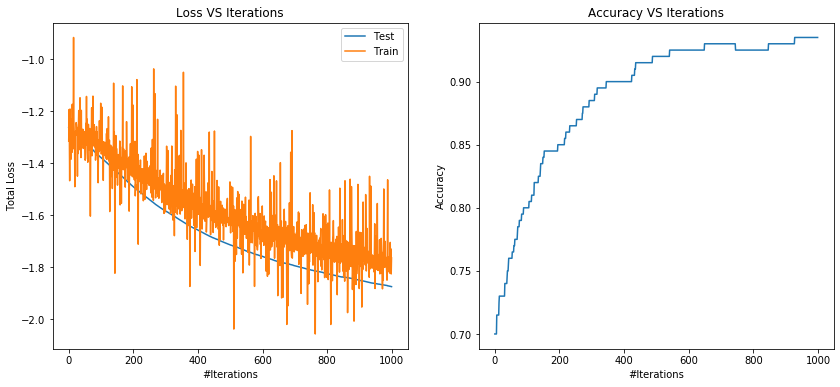

In [37]:
LR_exp(X1,y1,5,MBGD,lr=0.01,batch_size=256)

#### SGD

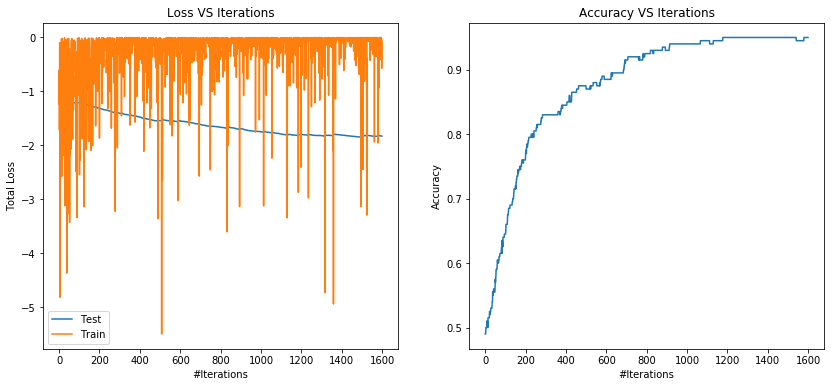

In [38]:
LR_exp(X1,y1,5,SGD,lr=0.01)

#### BGD

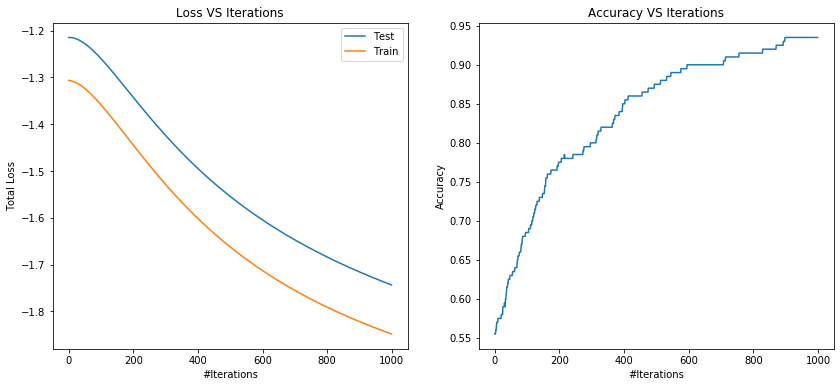

In [39]:
LR_exp(X1,y1,5,BGD,lr=0.01)

### Comparison of Momentum, SAG and GD

#### SGD

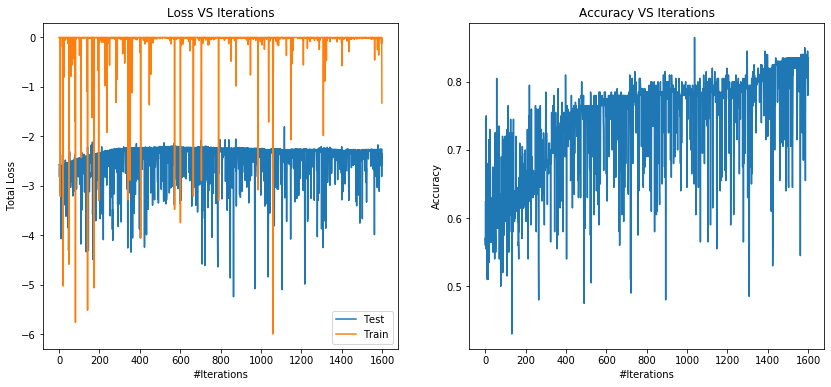

In [82]:
LR_exp(X1,y1,5,SGD,lr=1,momentum=True)

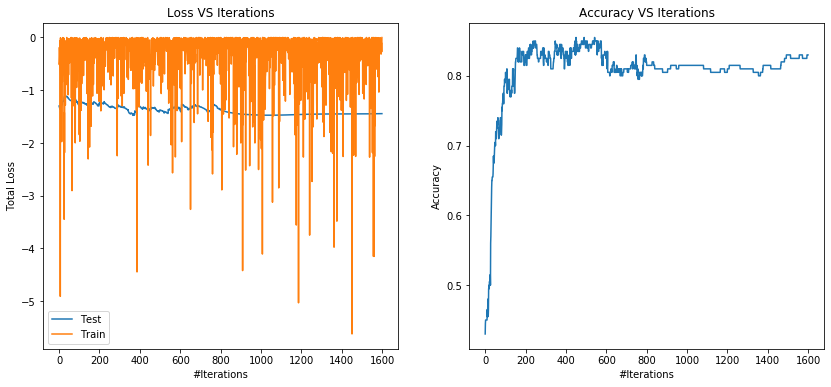

In [77]:
LR_exp(X1,y1,5,SGD,lr=0.05,saga=True)

#### BGD

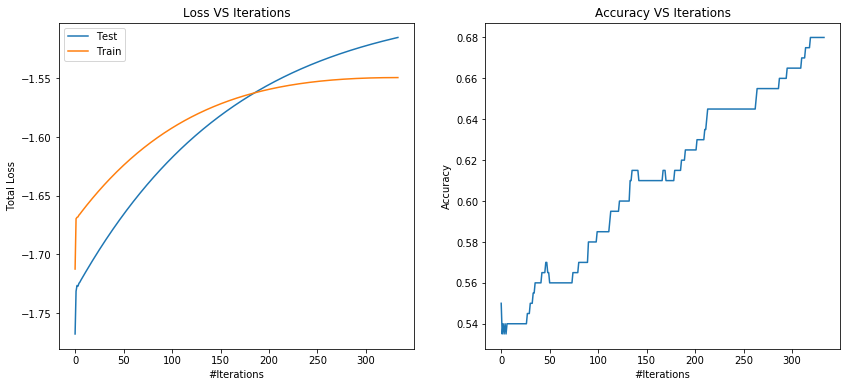

In [85]:
LR_exp(X1,y1,5,BGD,lr=1,momentum=True)

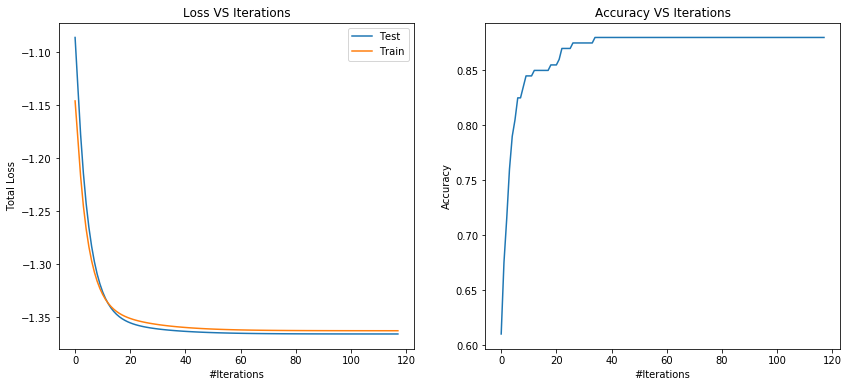

In [86]:
LR_exp(X1,y1,5,BGD,lr=1,saga=True)

### Compare on different Data Noise Level

#### Mini-Batch GD

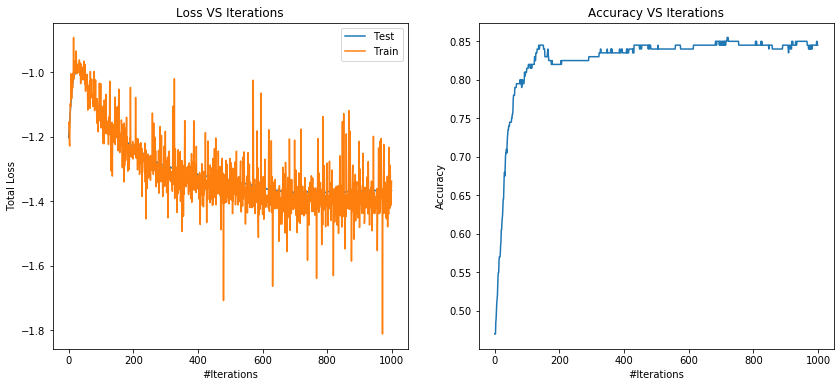

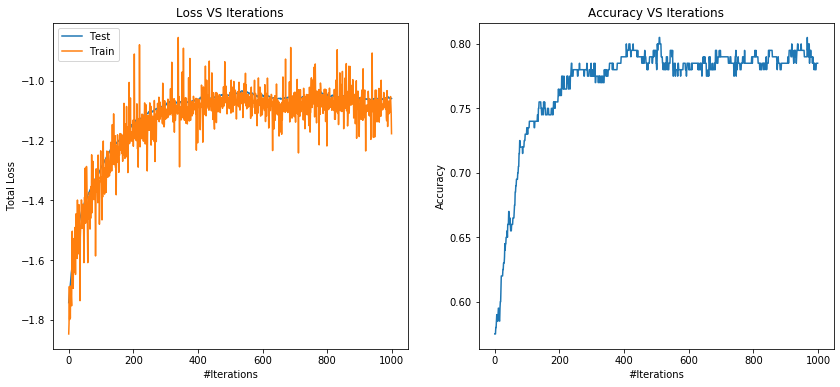

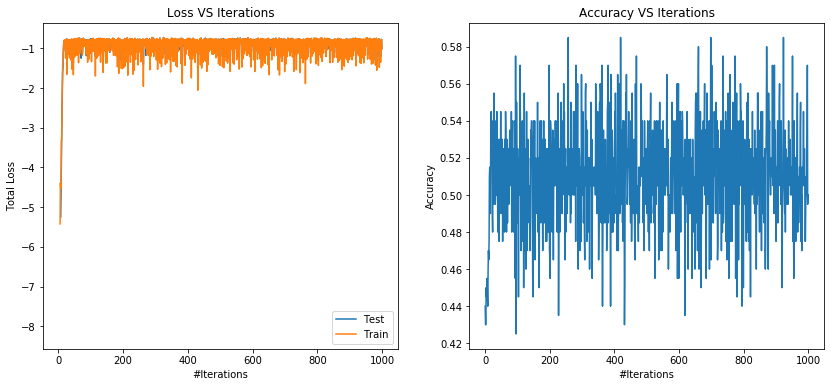

In [104]:
LR_exp(X1,y1,5,MBGD,lr=0.05,batch_size=256)
LR_exp(X1+np.random.randn(*X1.shape),y1,5,MBGD,lr=0.05,batch_size=256)
LR_exp(X1+10*np.random.randn(*X1.shape),y1,5,MBGD,lr=0.05,batch_size=256)

#### SGD

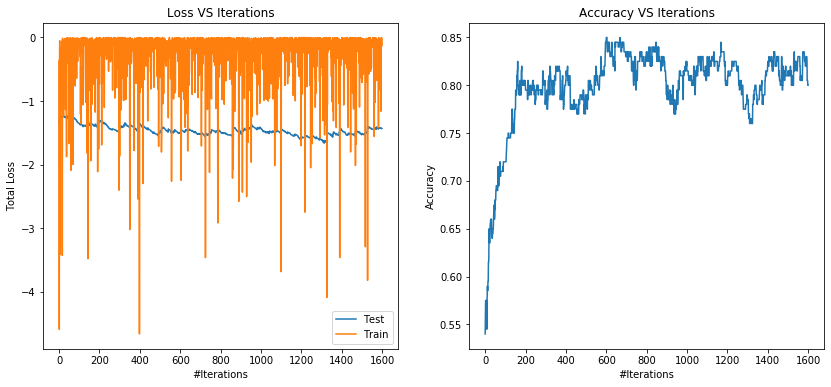

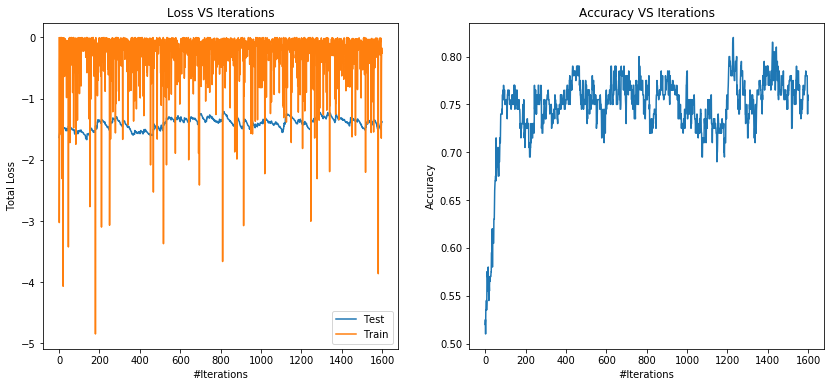

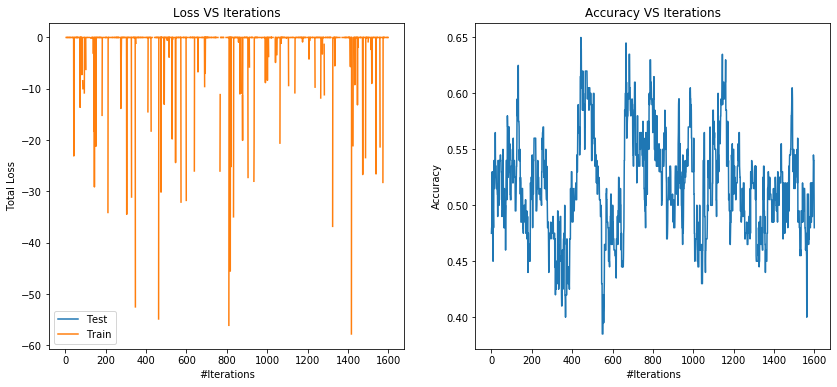

In [107]:
LR_exp(X1,y1,5,SGD,lr=0.05)
LR_exp(X1+np.random.randn(*X1.shape),y1,5,SGD,lr=0.05)
LR_exp(X1+10*np.random.randn(*X1.shape),y1,5,SGD,lr=0.05)

#### BGD

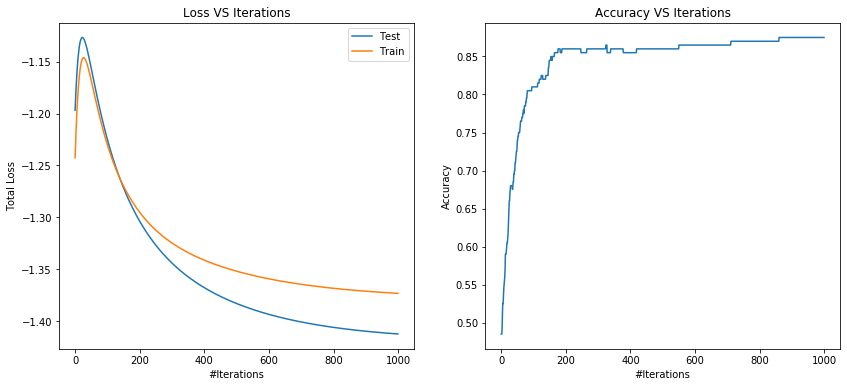

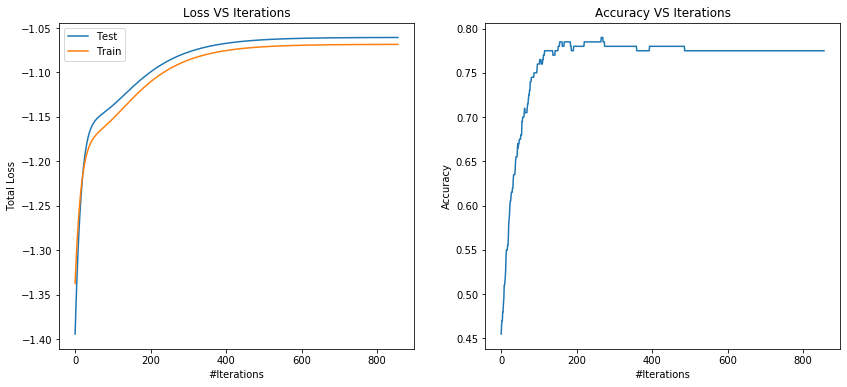

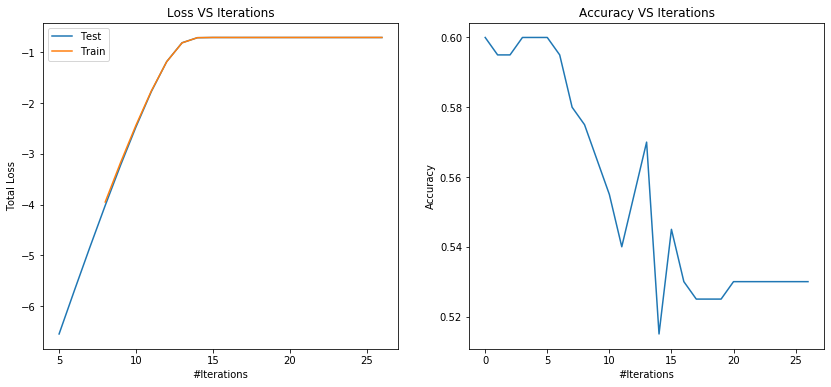

In [108]:
LR_exp(X1,y1,5,BGD,lr=0.05)
LR_exp(X1+np.random.randn(*X1.shape),y1,5,BGD,lr=0.05)
LR_exp(X1+10*np.random.randn(*X1.shape),y1,5,BGD,lr=0.05)